# New York City Cab Fare Data Wrangling

This files in this notebook were downloaded from the Kaggle Competition "New York City Taxi Fare Prediction" at https://www.kaggle.com/c/new-york-city-taxi-fare-prediction.

The purpose of this notebook is to explore the data in advance of a machine learning pipeline.

The overall goal of the project is to predict cab fare from the time of pickup, latitude & longitude of pickup, and latitude & longitude of drop-off.

## Imports

In [1]:
# Import Standard Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## First Look

In [2]:
%%time
# Since the dataset contains 55 million rows, it's worth looking at a subset first
df = pd.read_csv('train.csv', nrows=2500000)

CPU times: user 5.45 s, sys: 524 ms, total: 5.97 s
Wall time: 5.98 s


In [3]:
# Feather can speed up the process
import feather

In [4]:
%%time
# Save into feather format. Useful for entire dataset
df.to_feather('nyc_cab_fare_raw.feather')

CPU times: user 342 ms, sys: 187 ms, total: 530 ms
Wall time: 502 ms


In [5]:
%%time
# load the same dataframe next time directly, without reading the csv file again!
df = pd.read_feather('nyc_cab_fare_raw.feather')

/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


CPU times: user 507 ms, sys: 267 ms, total: 774 ms
Wall time: 781 ms


Note that the feather is definitely faster.

In [6]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


Note that there are very few columns

In [7]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.500000e+06,2.500000e+06,2.500000e+06,2.499981e+06,2.499981e+06,2.500000e+06
mean,1.134467e+01,-7.251697e+01,3.992710e+01,-7.251614e+01,3.992419e+01,1.684222e+00
std,9.838472e+00,1.286145e+01,8.343414e+00,1.267979e+01,1.007531e+01,1.326494e+00
min,-6.200000e+01,-3.377681e+03,-3.458665e+03,-3.383297e+03,-3.461541e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073492e+01,-7.399139e+01,4.073402e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075315e+01,1.000000e+00
75%,1.250000e+01,-7.396712e+01,4.076711e+01,-7.396368e+01,4.076811e+01,2.000000e+00
max,1.273310e+03,2.856442e+03,2.912465e+03,3.414307e+03,3.345917e+03,2.080000e+02


The min and max fare look totally unrealistic. Also note that there are more pickups than dropoffs.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500000 entries, 0 to 2499999
Data columns (total 8 columns):
key                  object
fare_amount          float64
pickup_datetime      object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      int64
dtypes: float64(5), int64(1), object(2)
memory usage: 152.6+ MB


Datetime values need to be converted. When opening again, it's worth parsing the dates.

### NaN Values

In [9]:
# Count number of reviews with no dropoff latitude
df.dropoff_latitude.isnull().sum()

19

In [10]:
# Check for null values
dfn = df[df.isnull().any(axis=1)]

In [11]:
# Display null values
dfn.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
120227,2012-12-11 12:57:00.00000013,12.5,2012-12-11 12:57:00 UTC,-73.992760,40.743098,NaN,NaN,0
245696,2013-03-21 18:07:07.0000001,86.5,2013-03-21 18:07:07 UTC,-73.991572,40.740591,NaN,NaN,0
340533,2012-12-11 12:50:52.00000010,27.5,2012-12-11 12:50:52 UTC,-73.979639,40.784742,NaN,NaN,0
428108,2011-09-08 09:12:52.0000001,11.8,2011-09-08 09:12:52 UTC,-73.987041,40.751542,NaN,NaN,0
471472,2012-12-11 12:34:20.0000006,7.8,2012-12-11 12:34:20 UTC,0.000000,0.000000,NaN,NaN,0


Since these rows all include fare amounts, they should be eliminated from the data. Had the cab just been running idle, the dropoff and pickup would have the same coordinates. Also note the pickup coordinates of 0. This must also be an error.

In [12]:
# Eliminate null values
df = df.dropna(axis=0, subset=['dropoff_latitude'])

In [13]:
# Verify that counts are the same
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.499981e+06,2.499981e+06,2.499981e+06,2.499981e+06,2.499981e+06,2.499981e+06
mean,1.134458e+01,-7.251699e+01,3.992711e+01,-7.251614e+01,3.992419e+01,1.684234e+00
std,9.838256e+00,1.286141e+01,8.343408e+00,1.267979e+01,1.007531e+01,1.326491e+00
min,-6.200000e+01,-3.377681e+03,-3.458665e+03,-3.383297e+03,-3.461541e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073492e+01,-7.399139e+01,4.073402e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075315e+01,1.000000e+00
75%,1.250000e+01,-7.396712e+01,4.076711e+01,-7.396368e+01,4.076811e+01,2.000000e+00
max,1.273310e+03,2.856442e+03,2.912465e+03,3.414307e+03,3.345917e+03,2.080000e+02


### Latitude Longitude Corrections

According to https://www.mapdevelopers.com/geocode_bounding_box.php, New York City has the following bounds: 

North Latitude: 40.917577 

South Latitude: 40.477399 

East Longitude: -73.700272 

West Longitude: -74.259090

All NYC Cab_Rides should at least start in the city.

In [14]:
# Find cab rides whose pickup or dropoff are within NYC boundaries
# Declare constants
latmin = 40.477399
latmax = 40.917577
longmin = -74.259090
longmax = -73.700272

# Create dataframe with correct coordinates
df = df[((((df['pickup_longitude']<=longmax) & (df['pickup_longitude']>=longmin)) & ((df['pickup_latitude']<=latmax) & (df['pickup_latitude']>=latmin)))) | ((((df['dropoff_longitude']<=longmax) % (df['dropoff_longitude']>=longmin)) & ((df['dropoff_latitude']<=latmax) & (df['dropoff_latitude']>=latmin))))]

In [15]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.448181e+06,2.448181e+06,2.448181e+06,2.448181e+06,2.448181e+06,2.448181e+06
mean,1.131885e+01,-7.397549e+01,4.075082e+01,-7.391202e+01,4.071625e+01,1.684248e+00
std,9.659214e+00,3.454573e-02,2.694462e-02,3.547697e+00,4.328501e+00,1.307127e+00
min,-6.200000e+01,-7.425882e+01,4.048254e+01,-2.125745e+03,-3.114339e+03,0.000000e+00
25%,6.000000e+00,-7.399228e+01,4.073654e+01,-7.399158e+01,4.073548e+01,1.000000e+00
50%,8.500000e+00,-7.398210e+01,4.075333e+01,-7.398060e+01,4.075382e+01,1.000000e+00
75%,1.250000e+01,-7.396836e+01,4.076750e+01,-7.396531e+01,4.076838e+01,2.000000e+00
max,5.000000e+02,-7.370044e+01,4.091748e+01,1.328726e+03,3.210337e+03,9.000000e+00


Some of the entries still don't make sense. Whereas the pickup might be correct, the min/max dropoffs are quite extreme.

According to https://www.mapdevelopers.com/geocode_bounding_box.php, the boundary of the United States is as follows.

North Latitude: 71.538800 

South Latitude: 18.776300 

East Longitude: -66.885417 

West Longitude: 170.595700

Sticking to the Mainland, California gives the following:
West Longitude: -124.482003

In [16]:
# Choose cab rides whose pickup and dropoff are the US Mainland
# Declare constants
latmin = 5.496100
latmax = 71.538800
longmin = -124.482003
longmax = -66.885417

# Create dataframe with correct coordinates
df = df[((((df['pickup_longitude']<=longmax) & (df['pickup_longitude']>=longmin)) & ((df['pickup_latitude']<=latmax) & (df['pickup_latitude']>=latmin)))) & ((((df['dropoff_longitude']<=longmax) & (df['dropoff_longitude']>=longmin)) & ((df['dropoff_latitude']<=latmax) & (df['dropoff_latitude']>=latmin))))]

In [17]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.445787e+06,2.445787e+06,2.445787e+06,2.445787e+06,2.445787e+06,2.445787e+06
mean,1.131492e+01,-7.397550e+01,4.075082e+01,-7.397456e+01,4.075114e+01,1.684259e+00
std,9.644843e+00,3.451188e-02,2.693137e-02,3.888050e-02,5.367417e-02,1.307023e+00
min,-6.200000e+01,-7.425882e+01,4.048254e+01,-8.680412e+01,5.500000e+00,0.000000e+00
25%,6.000000e+00,-7.399228e+01,4.073655e+01,-7.399159e+01,4.073555e+01,1.000000e+00
50%,8.500000e+00,-7.398211e+01,4.075334e+01,-7.398062e+01,4.075384e+01,1.000000e+00
75%,1.250000e+01,-7.396837e+01,4.076750e+01,-7.396539e+01,4.076839e+01,2.000000e+00
max,5.000000e+02,-7.370044e+01,4.091748e+01,-6.813470e+01,5.578333e+01,9.000000e+00


### Fare / Passenger Count Corrections

There still appear to be anomalies. There should not be 0 passengers in a taxi. According to https://www1.nyc.gov/nyc-resources/faq/484/how-many-passengers-are-allowed-in-a-taxiIf, 4 or 5 people are allowed in a taxi, plus one child under 9.

In [18]:
# Only choose cabs between 1 and 6 riders
df = df[(df['passenger_count'] < 7) & (df['passenger_count'] > 0)]

In [19]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.437167e+06,2.437167e+06,2.437167e+06,2.437167e+06,2.437167e+06,2.437167e+06
mean,1.132348e+01,-7.397549e+01,4.075081e+01,-7.397456e+01,4.075113e+01,1.690212e+00
std,9.653593e+00,3.452859e-02,2.693567e-02,3.890825e-02,5.374115e-02,1.305474e+00
min,-6.200000e+01,-7.425882e+01,4.048254e+01,-8.680412e+01,5.500000e+00,1.000000e+00
25%,6.000000e+00,-7.399228e+01,4.073654e+01,-7.399158e+01,4.073555e+01,1.000000e+00
50%,8.500000e+00,-7.398211e+01,4.075333e+01,-7.398062e+01,4.075384e+01,1.000000e+00
75%,1.250000e+01,-7.396837e+01,4.076750e+01,-7.396539e+01,4.076838e+01,2.000000e+00
max,5.000000e+02,-7.370044e+01,4.091748e+01,-6.813470e+01,5.578333e+01,6.000000e+00


This looks better, but there are still problems with the min max fares. Also, the max fare keeps coming up with a different passenger_count.

In [20]:
df[df['fare_amount']>=500]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
101885,2011-09-12 09:33:56.0000004,500.0,2011-09-12 09:33:56 UTC,-73.965961,40.640595,-73.965961,40.640595,1


It is possible that people are going to California and back, but even so, this messes with the data. We are presuming that the dropoff is the goal destination, but this won't always be the case.

As for minimums, no one should have a negative cab ride. According to Dr. Google, the NYC Taxi base fare recently increased from 2 to 2.50. A histogram should verify things.

## Histograms

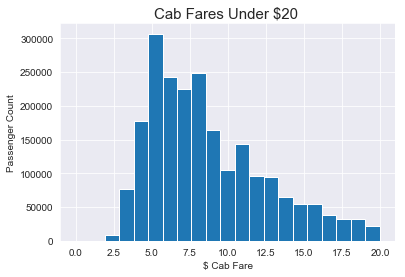

In [21]:
# Setup Seaborn
import seaborn as sns
sns.set_style("darkgrid")

# Create histogram of 20 bins showing fares from 0 to $20
plt.hist(df.fare_amount, bins=21, range=(0,20), ec='white')

# Create labels
plt.xlabel('$ Cab Fare')
plt.ylabel('Passenger Count')
plt.title('Cab Fares Under $20 ', fontsize=15)

# Save figure
plt.savefig("Cab_Fares_Under_20_Hist_s", dpi=300)

# Show graph
plt.show()

The histogram reveals that the mininum cab fare was 2.50 during the time period that the data was collected.

In [22]:
# Eliminate cab rides less than $2.50
df = df[df['fare_amount'] >= 2.50]

In [23]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.437005e+06,2.437005e+06,2.437005e+06,2.437005e+06,2.437005e+06,2.437005e+06
mean,1.132449e+01,-7.397549e+01,4.075082e+01,-7.397456e+01,4.075113e+01,1.690221e+00
std,9.652831e+00,3.452646e-02,2.693439e-02,3.890620e-02,5.374167e-02,1.305483e+00
min,2.500000e+00,-7.425882e+01,4.048254e+01,-8.680412e+01,5.500000e+00,1.000000e+00
25%,6.000000e+00,-7.399228e+01,4.073654e+01,-7.399158e+01,4.073555e+01,1.000000e+00
50%,8.500000e+00,-7.398211e+01,4.075333e+01,-7.398062e+01,4.075384e+01,1.000000e+00
75%,1.250000e+01,-7.396837e+01,4.076750e+01,-7.396539e+01,4.076838e+01,2.000000e+00
max,5.000000e+02,-7.370044e+01,4.091748e+01,-6.813470e+01,5.578333e+01,6.000000e+00


The min fare looks good, but the max seems quite high. Also, the dropoff latitude and longitude of the min are way out of range.

In the meantime, here is a histogram of all the cab fares.

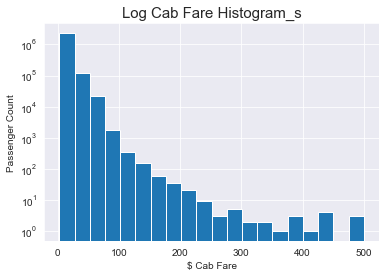

In [24]:
# Create log histogram of all current fares
plt.hist(df.fare_amount, bins=20, ec='white', log=True)
plt.xlabel('$ Cab Fare')
plt.ylabel('Passenger Count')
plt.title('Log Cab Fare Histogram_s', fontsize=15)
plt.savefig("Cab_Fare_Hist", dpi=300)
plt.show()

In [25]:
# Save file before adding new columns
# df.to_csv('NYC_Cab_Fare_Wrangled.csv')
# This was done on whole dataset. Uncomment above line so save.

## Euclidean Distance

I am going to define both a Euclidean Distance, an unrealistic min since the shortest distance between 2 points is not a straight line through buildings and blocks, and a Taxicab Distance, a more realistic expectation of miles traveled. The Euclidean distance will serve as a min to eliminate outliers and errors. 

In [26]:
# Define coordinates (x,y)
x1 = df['pickup_latitude']
y1 = df['pickup_longitude']
x2 = df['dropoff_latitude']
y2 = df['dropoff_longitude']

# Create Euclidean Distrance column
df['euclidean_distance'] = np.sqrt((y2-y1)**2 + (x2-x1)**2)

# Create Taxicab Distance column
df['taxicab_distance'] = np.abs(y2-y1) + np.abs(x2-x1)

# Convert to miles
df['euclidean_distance'] = df['euclidean_distance'] * 69
df['taxicab_distance'] = df['taxicab_distance'] * 69

# Show first five entries
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,euclidean_distance,taxicab_distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,0.651073,0.810198
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,5.499001,7.416189
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,0.943509,1.325628
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,1.748493,2.027634
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,1.343397,1.876386


#### Distance / Fare Plots

According to http://nymag.com/nymetro/urban/features/taxi/n_20286/, the going rate was $2.00 per mile. Therefore, since 2.50 is the minimum charge, there should be no fares less than the y = 2.5 + 2*x. (This is especially true with Euclidean Distance.)

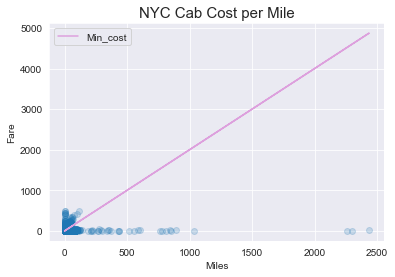

In [27]:
# Define x and y
x = df.euclidean_distance
y = df.fare_amount

# Create scatter plot
plt.scatter(x, y, alpha=0.2)

# Create labels
plt.ylabel('Fare')
plt.xlabel('Miles')

# Create title
plt.title('NYC Cab Cost per Mile', fontsize=15)

minLine, = plt.plot(x, 2.5 + 2*x, 'plum', label='Min_cost')

plt.legend(handles=[minLine])
plt.savefig('Cab Cost per Mile_s', dpi=300)
plt.show()

All rides underneath the plum line can be eliminated. Since the going rate was 2.50 per cab at 2.00 per mile in NYC, they are impossible.

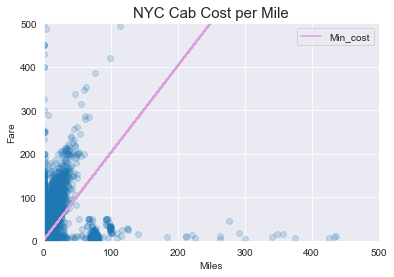

In [28]:
# Define x and y
x = df.euclidean_distance
y = df.fare_amount

# Prevent cell overflow
plt.rcParams['agg.path.chunksize'] = 10000

# Create scatter plot
plt.scatter(x, y, alpha=0.2)

# Create labels
plt.ylabel('Fare')
plt.xlabel('Miles')

# Create zoom limits
plt.xlim(0, 500)
plt.ylim(0, 500)

# Create title
plt.title('NYC Cab Cost per Mile', fontsize=15)

#Since helpful votes cannot exceed total votes, the cyan line represents a maximum. 
#All dots must be underneath the line
minLine, = plt.plot(x, 2.5 + 2*x, 'plum', label='Min_cost')

plt.legend(handles=[minLine])
plt.savefig('Cab Cost per Mile Zoom_s', dpi=300)
plt.show()

Note that the line looks pretty good, as in it's a nice separation of the data.

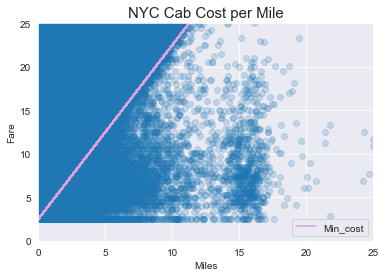

In [29]:
# Define x and y
x = df.euclidean_distance
y = df.fare_amount

# Prevent cell overflow
plt.rcParams['agg.path.chunksize'] = 10000

# Create scatter plot
plt.scatter(x, y, alpha=0.2)

# Create labels
plt.ylabel('Fare')
plt.xlabel('Miles')

# Create zoom limits
plt.xlim(0, 25)
plt.ylim(0, 25)

# Create title
plt.title('NYC Cab Cost per Mile', fontsize=15)

#Since helpful votes cannot exceed total votes, the cyan line represents a maximum. 
#All dots must be underneath the line
minLine, = plt.plot(x, 2.5 + 2*x, 'plum', label='Min_cost')

plt.legend(handles=[minLine])
plt.savefig('Cab Cost per Mile Zoom_s_2', dpi=300)
plt.show()

In [30]:
#### Eliminate unrealistic fares
df = df[df['fare_amount'] >= (df['euclidean_distance'] * 2 + 2.50)]

In [31]:
# Elminate fares that traveled no distance
df = df[df['euclidean_distance']>0]

## Updated Histograms

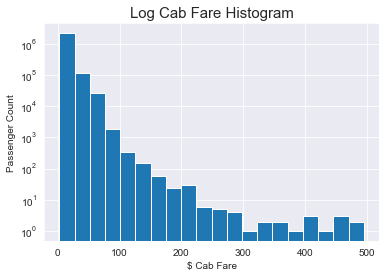

In [32]:
# Show updated log cab fare histogram
plt.hist(df.fare_amount, bins=20, ec='white', log=True)
plt.xlabel('$ Cab Fare')
plt.ylabel('Passenger Count')
plt.title('Log Cab Fare Histogram', fontsize=15)
plt.savefig("Cab_Fare_Hist_Updated_s", dpi=300)
plt.show()

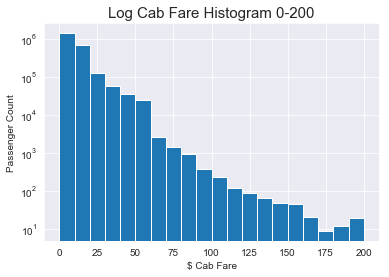

In [33]:
# Show zoomed in log cab fare histogram
plt.hist(df.fare_amount, bins=20, range=(0,200), ec='white', log=True)
plt.xlabel('$ Cab Fare')
plt.ylabel('Passenger Count')
plt.title('Log Cab Fare Histogram 0-200', fontsize=15)
plt.savefig("Cab_Fare_Hist_zoom_s", dpi=300)
plt.show()

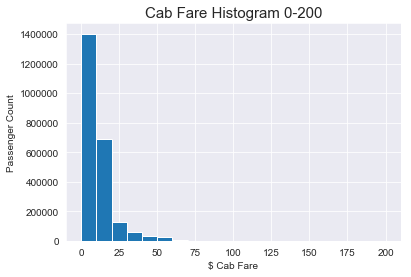

In [34]:
# Show zoomed in cab fare histogram
plt.hist(df.fare_amount, bins=20, range=(0,200), ec='white')
plt.xlabel('$ Cab Fare')
plt.ylabel('Passenger Count')
plt.title('Cab Fare Histogram 0-200', fontsize=15)
plt.savefig("Cab_Fare_Hist_0-200_s", dpi=300)
plt.show()

### Save File

In [35]:
# Save wrangled frame as csv file
#df.to_csv('NYC_Cab_Fare_Wrangled.csv')

In [36]:
# Get rid of accumulated garbage
import gc
gc.collect()

14586

## Time Series

In [37]:
#%%time

## If the kernel keeps dying, run statement underneath
## If running for the first time above, use parse_dates=['pickup_datetime']

#df = pd.read_csv('NYC_Cab_Fare_Wrangled.csv', parse_dates=['pickup_datetime'])

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2341765 entries, 0 to 2499999
Data columns (total 10 columns):
key                   object
fare_amount           float64
pickup_datetime       object
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
passenger_count       int64
euclidean_distance    float64
taxicab_distance      float64
dtypes: float64(7), int64(1), object(2)
memory usage: 196.5+ MB


In [39]:
# Check object
type(df.pickup_datetime[0])

str

In [40]:
def cut_UTC(row):
    row = row.split(' UTC')
    return row[0]

In [41]:
# Eliminate 'UTC'
df['pickup_datetime'] = df['pickup_datetime'].apply(cut_UTC)

In [42]:
# Convert to datetime
df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'], errors='ignore')

In [43]:
# Check type
type(df.pickup_datetime[0])

pandas._libs.tslibs.timestamps.Timestamp

#### Add new Time Columns

In [44]:
df['month'] = df['pickup_datetime'].dt.month
df['year'] = df['pickup_datetime'].dt.year
df['hour'] = df['pickup_datetime'].dt.hour
df['minute'] = df['pickup_datetime'].dt.minute
df['second'] = df['pickup_datetime'].dt.second
df['dayofweek'] = df['pickup_datetime'].dt.dayofweek

In [45]:
df['15_min_intervals'] = 4 * df['hour'] + (df['minute']/15).astype(int)
df['total_seconds'] = 3600 * df['hour'] + 60 * df['minute'] + df['second']

In [46]:
def summer_month(row):
    if row['month'] in [6,7,8]:
        return 1
    else:
        return 0

df['summer_month'] = df.apply(summer_month, axis=1)

In [47]:
def cold_month(row):
    if row['month'] in [1,2,3,11,12]:
        return 1
    else:
        return 0
    
df['cold_month'] = df.apply(cold_month, axis=1)

In [48]:
def weekend(row):
    if row['dayofweek'] in [5,6]:
        return 1
    else:
        return 0

df['weekend'] = df.apply(weekend, axis=1)

In [49]:
def rush_hour(row):
    if (row['hour'] in [7,8,9,15,16,17,18,19]) & (row['weekend'] == 0):
        return 1
    else:
        return 0

df['rush_hour'] = df.apply(rush_hour, axis=1)

In [50]:
def night_rush(row):
    if (row['hour'] in [19,20,21,22,23,24,1]) & (row['dayofweek'] in [3,4,5]):
        return 1
    else:
        return 0
    
df['night_rush'] = df.apply(night_rush, axis=1)

In [51]:
def night_charge(row):
    if row['hour'] in [20,21,22,23,24,1,2,3,4,5,6]:
        return 1
    else:
        return 0
    
df['night_charge'] = df.apply(night_charge, axis=1)

In [52]:
def weekday_surcharge(row):
    if (row['hour'] in [16,17,18,19,20]) & (row['dayofweek'] in [1,2,3,4,5]):
        return 1
    else:
        return 0
    
df['weekday_surcharge'] = df.apply(weekday_surcharge, axis=1)

In [53]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,euclidean_distance,taxicab_distance,...,dayofweek,15_min_intervals,total_seconds,summer_month,cold_month,weekend,rush_hour,night_rush,night_charge,weekday_surcharge
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,0.651073,0.810198,...,0,69,62781,1,0,0,1,0,0,0
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,5.499001,7.416189,...,1,67,60736,0,1,0,1,0,0,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,0.943509,1.325628,...,3,2,2100,1,0,0,0,0,0,0
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,1.748493,2.027634,...,5,18,16242,0,0,1,0,0,1,0
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,1.343397,1.876386,...,1,31,28260,0,1,0,1,0,0,0


In [54]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,euclidean_distance,taxicab_distance,month,year,...,dayofweek,15_min_intervals,total_seconds,summer_month,cold_month,weekend,rush_hour,night_rush,night_charge,weekday_surcharge
count,2.341765e+06,2.341765e+06,2.341765e+06,2.341765e+06,2.341765e+06,2.341765e+06,2.341765e+06,2.341765e+06,2.341765e+06,2.341765e+06,...,2.341765e+06,2.341765e+06,2.341765e+06,2.341765e+06,2.341765e+06,2.341765e+06,2.341765e+06,2.341765e+06,2.341765e+06,2.341765e+06
mean,1.152113e+01,-7.397572e+01,4.075079e+01,-7.397479e+01,4.075111e+01,1.693067e+00,2.384500e+00,3.082348e+00,6.268291e+00,2.011772e+03,...,3.039056e+00,5.563739e+01,5.050945e+04,2.369926e-01,4.209995e-01,2.818793e-01,3.002957e-01,1.513820e-01,3.288088e-01,2.021907e-01
std,9.675391e+00,3.419497e-02,2.672575e-02,3.420852e-02,3.089298e-02,1.307217e+00,2.667982e+00,3.472608e+00,3.440202e+00,1.869036e+00,...,1.947631e+00,2.602931e+01,2.342786e+04,4.252378e-01,4.937196e-01,4.499149e-01,4.583866e-01,3.584209e-01,4.697805e-01,4.016337e-01
min,2.600000e+00,-7.425819e+01,4.048254e+01,-7.470368e+01,3.938390e+01,1.000000e+00,6.900000e-05,6.900000e-05,1.000000e+00,2.009000e+03,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.100000e+00,-7.399234e+01,4.073648e+01,-7.399165e+01,4.073535e+01,1.000000e+00,9.141484e-01,1.166376e+00,3.000000e+00,2.010000e+03,...,1.000000e+00,3.700000e+01,3.408000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.500000e+00,-7.398218e+01,4.075328e+01,-7.398075e+01,4.075374e+01,1.000000e+00,1.532509e+00,1.975332e+00,6.000000e+00,2.012000e+03,...,3.000000e+00,5.800000e+01,5.284200e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.290000e+01,-7.396868e+01,4.076741e+01,-7.396585e+01,4.076825e+01,2.000000e+00,2.703742e+00,3.550232e+00,9.000000e+00,2.013000e+03,...,5.000000e+00,7.800000e+01,7.033300e+04,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
max,4.950000e+02,-7.370058e+01,4.091746e+01,-7.219609e+01,4.152588e+01,6.000000e+00,1.137633e+02,1.332743e+02,1.200000e+01,2.015000e+03,...,6.000000e+00,9.500000e+01,8.639900e+04,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [55]:
#df.to_csv('/Users/coreyjwade/Desktop/Data/NY_Cab_Fare/NYC_Cab_Fare_Wrangled_Time_Distance.csv')

## Latitude Longitude Additions

In [56]:
#df = pd.read_csv('NYC_Cab_Fare_Wrangled_Time_Distance.csv')

I used https://getlatlong.net/ to estimate a geographical area for Manhattan.

There are 4 points, that when connected as a quadrilateral, enclose most of Manhattan. (I chose some points in the water since they are unaffected traffic

Then for any given point (x,y) both of the following conditions must hold:

-  bottom line <= (x,y) <= top line
-  right line <= (x,y) <= left line

Or, equilavlently,
-  bottom line <= mx + b <= top line
-  right line <= mx + b <= left line

For instance, to determine if (3,4) <= 2x+1,
the condition must be checked that

 -  4 <= 2(3) + 1

which in this case is true.

In [57]:
# Define line from two points and a provided column
def two_points_line(a, b, column):
        
    # Case when y-values are the same
    if b[1]==a[1]:
        
        # Slope defaults to 0
        slope = 0
        
    # Case when x-values are the same
    elif b[0]==a[0]:
        
        # Case when max value is less than 999999999
        if column.max() < 999999999:
            
            # Add 999999999 to max value
            slope = column.max() + 999999999
        
        # All other cases
        else:
            
            # Multiply max value by itself (greater than 999999999)
            slope = column.max() * column.max()
    
    # When x-values and y-values are not 0
    else:
        
        # Use standard slope formula
        slope = (b[1] - a[1])/(b[0]-a[0])
    
    
    # Equation for y-intercept (solving y=mx+b for b)
    y_int = a[1] - slope * a[0]
    
    # Return slope and y-intercept
    return slope, y_int

#### Manhattan Coordinates

In [69]:
def manhattan_pickup(row):
    if (((row['pickup_latitude'] <= (row['pickup_longitude'] * m_top + b_top)) &
    (row['pickup_latitude'] >= (row['pickup_longitude'] * m_bottom + b_bottom))) &
    ((row['pickup_latitude'] >= (row['pickup_longitude'] * m_right + b_right)) &
    (row['pickup_latitude'] <= (row['pickup_longitude'] * m_left + b_left)))):
        return 1
    else:
        return 0

df['manhattan_pickup'] = df.apply(manhattan_pickup, axis=1)

In [70]:
def manhattan_dropoff(row):
    if (((row['dropoff_latitude'] <= (row['dropoff_longitude'] * m_top + b_top)) &
    (row['dropoff_latitude'] >= (row['dropoff_longitude'] * m_bottom + b_bottom))) &
    ((row['dropoff_latitude'] >= (row['dropoff_longitude'] * m_right + b_right)) &
    (row['dropoff_latitude'] <= (row['dropoff_longitude'] * m_left + b_left)))):
        return 1
    else:
        return 0

df['manhattan_dropoff'] = df.apply(manhattan_dropoff, axis=1)

## Save file

In [ ]:
#df.to_csv('NYC_Cab_Fare_Wrangled_Time_Distance.csv')